In [1]:
!pip install numpy=="2.2.5" scipy=="1.15.2"

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve, inv
from scipy.optimize import fsolve
from scipy.sparse.linalg import gmres

/home/nevskys/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
def initial_point(c, theta):
    n  = c.size
    e  = np.ones(n)
    
    x0 = np.zeros(n)
    y0 = e
    z0 = e
    mu0 = 4 * (1 + norm(c) ** 2)
    
    lam0 = mu0 - c / 2
    gam0 = mu0 + c / 2
    
    return x0, y0, z0, lam0, gam0, mu0

In [4]:
def kappa(x, y, z, lam, gam, mu, H, c):
    n = c.size
    e = np.ones(n)
    Hx = H @ x
    rX = Hx + lam - gam + c
    rY = x + y - e
    rZ = x - z + e
    ret = (norm(rY) + norm(rZ)) / (2 * n) + \
           norm(rX) / max(1, norm(c)) + \
           mu / max(1, norm(x @ (Hx + c)))
    return ret

In [5]:
from scipy.sparse.linalg import LinearOperator, gmres, minres, bicgstab

def make_A_op(H, lam, y, gam, z):
    n = H.shape[0]
   
    Yi    = 1.0 / y
    B     = z * Yi
    diag0 = B*lam + gam         
    Hd    = H.diagonal()        
    diagA = diag0 + z * Hd
    P     = 1.0 / diagA      

    def matvec(v):
        Hz = H.dot(v)          
        out = z * Hz
        out += diag0 * v
        return P * out

    return LinearOperator((n,n), matvec, dtype=float), P

In [6]:
def newton_step(H, lam, y, gam, z, tol=1e-5, restart=50, symm=False):
    """
    Returns x_d, y_d, ... gam_d, x_dd, ..., gam_dd
    using two Krylov solves against the same operator.
    """
    n = H.shape[0]

    # build operator and P
    A_op, P = make_A_op(H, lam, y, gam, z)

    # precompute some vectors
    Yi = 1.0 / y
    a  = lam * y
    b  = gam * z

    # RHS1 = P * (b - B*a) with B = z * Yi
    B  = z * Yi
    rhs1 = P * (b - B*a)

    # choose solver: symmetric‐indefinite minres or general gmres
    solve = (lambda A, rhs: minres(A, rhs, rtol=tol)[0]) if symm else (lambda A, rhs: bicgstab(A, rhs, rtol=tol)[0])

    x_d = solve(A_op, rhs1)
    y_d = -x_d
    z_d =  x_d
    lam_d = Yi * (lam * x_d + a)
    gam_d = lam_d + H.dot(x_d)

    # form second RHS
    a_dot = -2 * lam_d * y_d
    b_dot = -2 * gam_d * z_d
    rhs2  = P * (b_dot - B*a_dot)

    x_dd = solve(A_op, rhs2)
    y_dd = -x_dd
    z_dd =  x_dd
    lam_dd = Yi * (lam * x_dd - 2 * lam_d * y_d)
    gam_dd = lam_dd + H.dot(x_dd)

    return x_d, y_d, z_d, lam_d, gam_d, x_dd, y_dd, z_dd, lam_dd, gam_dd

In [7]:
"""
def newton_step(H, lam, y, gam, z):
    Yi = 1.0 / y
    B  = z * Yi
    a  = lam * y
    b  = gam * z

    A = H.copy()
    A *= z[:, None]
    A += np.diag(B * lam + gam)
    diagA = B * lam + gam + z * H.diagonal() 
    P = 1.0 / diagA
    A *= P[:, None] 

    rhs1 = P * (b - B * a)
    x_d, _ = gmres(A, rhs1, rtol=1e-6, restart=50)
    lam_d = Yi * (lam * x_d + a)
    gam_d = lam_d + H @ x_d

    a_dot =  2 * lam_d * x_d
    b_dot = -2 * gam_d * x_d

    rhs2 = P * (b_dot - B * a_dot)
    x_dd, _ = gmres(A, rhs2, rtol=1e-6, restart=50)
    lam_dd = Yi * (lam * x_dd + 2 * lam_d * x_d)
    gam_dd = lam_dd + H @ x_dd

    return x_d, -x_d, x_d, lam_d, gam_d, x_dd, -x_dd, x_dd, lam_dd, gam_dd
"""

'\ndef newton_step(H, lam, y, gam, z):\n    Yi = 1.0 / y\n    B  = z * Yi\n    a  = lam * y\n    b  = gam * z\n\n    A = H.copy()\n    A *= z[:, None]\n    A += np.diag(B * lam + gam)\n    diagA = B * lam + gam + z * H.diagonal() \n    P = 1.0 / diagA\n    A *= P[:, None] \n\n    rhs1 = P * (b - B * a)\n    x_d, _ = gmres(A, rhs1, rtol=1e-6, restart=50)\n    lam_d = Yi * (lam * x_d + a)\n    gam_d = lam_d + H @ x_d\n\n    a_dot =  2 * lam_d * x_d\n    b_dot = -2 * gam_d * x_d\n\n    rhs2 = P * (b_dot - B * a_dot)\n    x_dd, _ = gmres(A, rhs2, rtol=1e-6, restart=50)\n    lam_dd = Yi * (lam * x_dd + 2 * lam_d * x_d)\n    gam_dd = lam_dd + H @ x_dd\n\n    return x_d, -x_d, x_d, lam_d, gam_d, x_dd, -x_dd, x_dd, lam_dd, gam_dd\n'

In [8]:
def step_along_arc( x   , y   , z   , lam   , gam  \
                  , x_d , y_d , z_d , lam_d , gam_d \
                  , x_dd, y_dd, z_dd, lam_dd, gam_dd \
                  , sin_a, mu): 
    n     = x.size
    cos_a = np.sqrt(1 - sin_a**2)
    upd   = lambda v, v_d, v_dd: v - v_d * sin_a + v_dd * (1 - cos_a)

    p_d  = np.concatenate([  y_d ,   z_d ])
    w_d  = np.concatenate([lam_d , gam_d ])
    p_dd = np.concatenate([  y_dd,   z_dd])
    w_dd = np.concatenate([lam_dd, gam_dd])
    
    mu_a = mu * (1 - sin_a)                                          \
         + (                                                         \
               (p_dd @ w_dd - p_d  @ w_d) *         (1 - cos_a)**2 - \
               (p_d  @ w_dd + p_dd @ w_d) * sin_a * (1 - cos_a)      \
           ) / (2 * n)
    
    return (
        upd(  x,   x_d,   x_dd),
        upd(  y,   y_d,   y_dd),
        upd(  z,   z_d,   z_dd),
        upd(lam, lam_d, lam_dd),
        upd(gam, gam_d, gam_dd),
        mu_a
    )

In [9]:
def correct_step(H, lam, y, gam, z, mu, tol=1e-6, restart=50, symm=False):
    """
    Returns dx, dy, dz, dlam, dgam
    by solving one linear system via the same trick.
    """
    n = H.shape[0]

    # build operator
    A_op, P = make_A_op(H, lam, y, gam, z)

    # build RHS = P * (b - B*a)
    Yi = 1.0 / y
    e  = np.ones(n)
    B  = z * Yi
    a  = mu*e - lam*y
    b  = mu*e - gam*z
    rhs = P * (b - B*a)

    solve = (lambda A, rhs: minres(A, rhs, rtol=tol)[0]) if symm else (lambda A, rhs: bicgstab(A, rhs, rtol=tol)[0])

    dx = solve(A_op, rhs)
    dy = -dx
    dz =  dx
    dlam = Yi * (lam * dx + a)
    dgam = dlam + H.dot(dx)

    return dx, dy, dz, dlam, dgam

In [10]:
"""
def correct_step(H, lam_a, y_a, gam_a, z_a, mu_a):
    n = lam_a.size
    e = np.ones(n)

    Yi = 1.0 / y_a
    B  = z_a / y_a
    a  = mu_a * e - lam_a * y_a
    b  = mu_a * e - gam_a * z_a

    A = H.copy()
    A *= z_a[:, None]
    A += np.diag(B * lam_a + gam_a)
    diagA = B * lam_a + gam_a + z_a * H.diagonal() 
    P = 1.0 / diagA
    A *= P[:, None] 
  
    rhs = P * (b - B * a)
    dx, _ = gmres(A, rhs, rtol=1e-6, restart=50)
    dlam = Yi * (lam_a * dx + a)
    dgam = dlam + H @ dx
    
    return dx, -dx, dx, dlam, dgam
"""
def update(x, y, z, lam, gam, mu, H):
    n   = x.size
    upd = lambda v, dv: v + dv
    
    dx, dy, dz, dlam, dgam = correct_step(H, lam, y, gam, z, mu)
    
    x1   = x + dx
    y1   = y + dy
    z1   = z + dz
    lam1 = lam + dlam
    gam1 = gam + dgam
    mu1  = (y1 @ lam1 + z1 @ gam1) / (2 * n)
    
    return x1, y1, z1, lam1, gam1, mu1

In [11]:
def step_size(mu, theta, x_d, p_d, w_d, p_dd, w_dd, sigma):
    n = p_d.size
    e = np.ones(n)
    
    sin_a_flat = fsolve(
        lambda x: mu * (1 - x) - (p_d @ w_d) * (x**4 + x**2) / (2 * n) - sigma,
        0.99
    )
    
    b0 = -theta * mu
    b1 = -b0
    p_d_w_dd = p_d  @ w_dd
    p_dd_w_dd = p_dd @ w_dd
    w_d_p_dd = w_d @ p_dd
    w_d_p_d = w_d @ p_d
    b3 = norm(p_d  * w_dd + w_d * p_dd - (p_d_w_dd + w_d_p_dd) * e / (2 * n)) + theta / n * (p_d_w_dd + w_d_p_dd)
    b4 = norm(p_dd * w_dd - w_d * p_d  - (p_dd_w_dd - w_d_p_d) * e / (2 * n)) - theta / n * (p_dd_w_dd - w_d_p_d)
    
    b0_hat = b0
    b1_hat = b1
    b3_hat = b3 if b3 >= 0 else 0
    b4_hat = b4 if b4 >= 0 else 0
    
    sin_a_wave = fsolve(
        lambda x: (
            b4_hat *     (1 - np.sqrt(1 - x**2))**2 +
            b3_hat * x * (1 - np.sqrt(1 - x**2))    +
            b1_hat * x                              +
            b0_hat
        ),
        0.99
    )
    
    a0 = b0
    a1 = b1
    a2 = theta * (x_d @ (H @ x_d)) / n
    a3 = norm(p_d  * w_dd + w_d * p_dd - (p_d  @ w_dd + w_d @ p_dd) * e / (2 * n))
    a4 = norm(p_dd * w_dd - w_d * p_d  - (p_dd @ w_dd - w_d @ p_d ) * e / (2 * n)) + a2
    
    sin_a_strike = fsolve(
        lambda x: a4 * x**4 + a3 * x**3 + a2 * x**2 + a1 * x + a0,
        0.99
    )
    
    sin_a_galka = max(sin_a_wave, sin_a_strike)
    
    beta  = p_dd_w_dd / (2 * n * mu)
    bi2   =  1 / (2 * beta)
    one63 = (1 / 6)**3
    
    a_C1_galka = (
        np.pi / 2 if beta <= 1 / 6 else
        np.arcsin(
            np.cbrt(bi2 + np.sqrt(bi2**2 + one63)) +
            np.cbrt(bi2 - np.sqrt(bi2**2 + one63))
        )
    )
    
    return min(sin_a_flat, sin_a_galka, np.sin(a_C1_galka))

In [12]:
def solve_qp_arcsearch(H, c, theta=0.19, eps=1e-8, sigma=1e-10, max_iter=50):
    x, y, z, lam, gam, mu = initial_point(c, theta)
    k = kappa(x, y, z, lam, gam, mu, H, c)
    
    dual_meas_hist = []
    step_hist      = []
    loss_hist      = []
    gap_hist       = []
    
    for it in range(max_iter):
        if k <= eps:
            break

        # 1) Newton step
        x_d, y_d, z_d, lam_d, gam_d, x_dd, y_dd, z_dd, lam_dd, gam_dd = newton_step(H, lam, y, gam, z)

        # 2) Choose new step
        p_d  = np.concatenate([   y_d,    z_d])
        w_d  = np.concatenate([ lam_d,  gam_d])
        p_dd = np.concatenate([  y_dd,   z_dd])
        w_dd = np.concatenate([lam_dd, gam_dd])
        
        sin_a = step_size(mu, theta, x_d, p_d, w_d, p_dd, w_dd, sigma)

        # 3) Do step along arc
        x_a, y_a, z_a, lam_a, gam_a, mu_a = step_along_arc \
        (
            x   , y   , z   , lam   , gam   , \
            x_d , y_d , z_d , lam_d , gam_d , \
            x_dd, y_dd, z_dd, lam_dd, gam_dd, \
            sin_a, mu                         \
        )

        # 4) Back to proximal vicinity: N(2O) -> N(O)
        x, y, z, lam, gam, mu = update(x_a, y_a, z_a, lam_a, gam_a, mu_a, H)

        #print(y)
        assert (y >= 0).all()
        assert (z >= 0).all()
        assert (lam >= 0).all()
        assert (mu >= 0).all()

        # 5) Update kappa for termination criteria
        k = kappa(x, y, z, lam, gam, mu, H, c)

        dual_meas_hist.append(mu)
        step_hist     .append(sin_a)
        #loss_hist     .append(0.5 * x @ (H @ x) + c @ x)
        gap_hist      .append(k)
        
        #print("mu: ", mu)
        #print("Kappa: ", k)
        #print("Step: ", sin_a)
    return x, dual_meas_hist, step_hist, loss_hist, gap_hist

In [13]:
import numpy as np

def compute_lqr_matrices_optimized(A, B, P, Q, R, x0, N):
    """
    Computes H and c matrices for the LQR problem with horizon N, optimized for matrix powers.
    
    Parameters:
    - A  (ndarray): State transition matrix (r x r)
    - B  (ndarray): Input            matrix (r x m)
    - P  (ndarray): Terminal cost    matrix (r x r)
    - Q  (ndarray): State    cost    matrix (r x r)
    - R  (float  ): Control  cost    scalar
    - x0 (ndarray): Initial  state   vector (r x 1)
    - N  (int    ): Horizon length
    
    Returns:
    - H (ndarray): Quadratic cost matrix (N*m x N*m)
    - c (ndarray): Linear    cost vector (N*m x 1  )
    """
    r, m = B.shape
    
    powers = [B]
    for i in range(1, N):
        powers.append(A @ powers[-1])  # [B, A B, A^2 B, ..., A^{N-1} B]
    
    x_k = [x0]
    for k in range(1, N + 1):
        x_k.append(A @ x_k[-1])  # [x0, A x0, A^2 x0, ..., A^N x0]
    
    # Compute phi_N = [A^{N-1} B, A^{N-2} B, ..., B]
    phiN = np.hstack(powers[::-1])
    H    = phiN.  T @ P @ phiN  # Terminal cost contribution
    c    = x_k[N].T @ P @ phiN  # Terminal cost linear term
    
    # Stage costs
    for k in range(1, N):
        # phi_k = [A^{k-1} B, A^{k-2} B, ..., B]
        phi_k = np.hstack(powers[:k][::-1])
        H[:k*m, :k*m] += phi_k. T @ Q @ phi_k  # Stage cost quadratic term
        c[:k*m      ] += x_k[k].T @ Q @ phi_k  # Stage cost linear term
    
    H += np.eye(N*m) * R  # Control cost contribution
    c = c.flatten()
    return H, c

In [14]:
T = 50.0
N = 1000
h = T / N

# System matrices
A = np.array([[1, h], [-h, 1]])
B = np.array([[0], [h]])

# Cost weights
P = np.array([[2, 0], [0, 1]])
Q = P.copy()
R = 6.0

# Initial state
x0 = np.array([15.0, 5.0])

# Compute H and c
H, c = compute_lqr_matrices_optimized(A, B, P, Q, R, x0, N)

In [15]:
import time
# Solve using arc-search QP
start = time.time()
u_opt, dual_meas, step, loss, gap = solve_qp_arcsearch(H, c, theta=0.19, eps=1e-8, sigma=1e-10, max_iter=100)
end = time.time()
print(end - start)

0.3072206974029541


In [16]:
import cProfile
cProfile.run("solve_qp_arcsearch(H, c)")

         51539 function calls in 0.378 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 119512835.py:1(initial_point)
       39    0.001    0.000    0.140    0.004 1318456837.py:1(correct_step)
       39    0.000    0.000    0.130    0.003 1318456837.py:19(<lambda>)
       39    0.001    0.000    0.003    0.000 1562022103.py:1(step_along_arc)
      195    0.002    0.000    0.002    0.000 1562022103.py:7(<lambda>)
       39    0.002    0.000    0.175    0.004 1715893430.py:1(newton_step)
       78    0.000    0.000    0.153    0.002 1715893430.py:21(<lambda>)
     1331    0.009    0.000    0.235    0.000 1883138548.py:13(matvec)
       78    0.001    0.000    0.004    0.000 1883138548.py:3(make_A_op)
       40    0.003    0.000    0.005    0.000 273224142.py:1(kappa)
        1    0.002    0.002    0.378    0.378 3234165827.py:1(solve_qp_arcsearch)
       39    0.024    0.001    0.

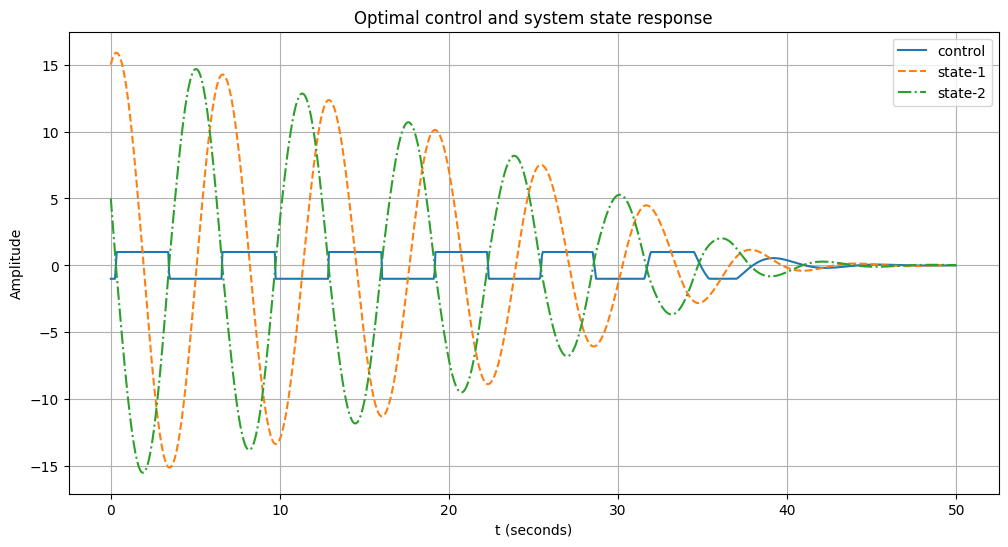

In [17]:
# time axis
t = np.linspace(0, T, N + 1)
x_traj = np.zeros((2, N + 1))
x_traj[:, 0] = x0
for k in range(N):
    u = u_opt[k]
    x_traj[:, k + 1] = A @ x_traj[:, k] + B.flatten() * u
# plot
plt.figure(figsize=(12,6))
plt.plot(t[:-1], u_opt, label='control')
plt.plot(t, x_traj[0, :], '--', label='state-1')
plt.plot(t, x_traj[1, :], '-.', label='state-2')
plt.xlabel('t (seconds)')
plt.ylabel('Amplitude')
plt.title('Optimal control and system state response')
plt.legend()
plt.grid(True)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (0,) and (39,)

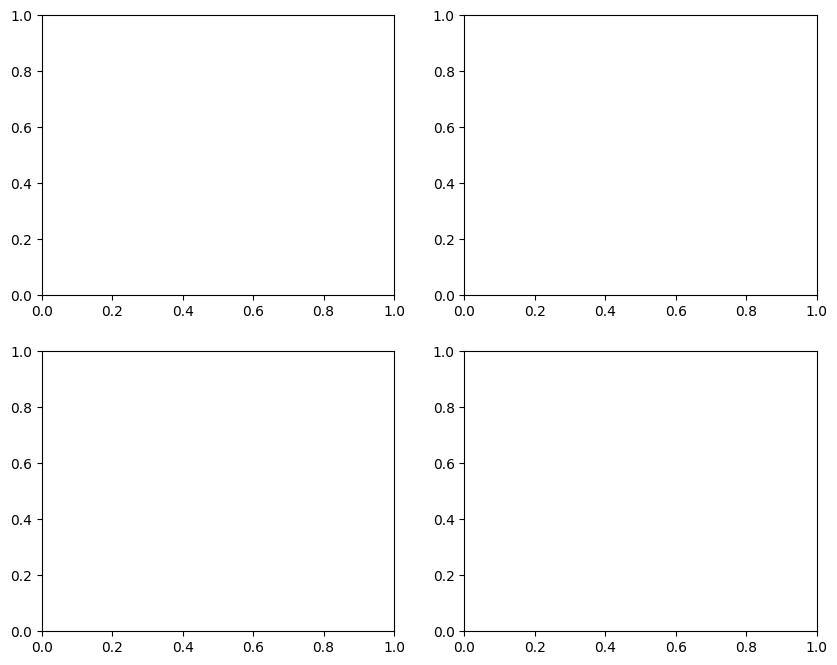

In [18]:
# Create iteration numbers for x-axis
iterations = np.arange(len(loss))

# Create a figure with 4 subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # Flatten to easily iterate over subplots

# List of parameters and their names
parameters = [dual_meas, step, loss, gap]
param_names = ['Dual Measure', 'Step', 'Loss', 'Gap']

# Plot each parameter in its subplot
for i, (param, name) in enumerate(zip(parameters, param_names)):
    axes[i].plot(iterations, param, 'b-')
    axes[i].set_title(name)
    axes[i].set_xlabel('Iteration Number')
    axes[i].set_ylabel(name)
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file
plt.show()